In [2]:
### Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)

!pip install geopandas
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

     |████████████████████████████████| 972kB 8.8MB/s 
     |████████████████████████████████| 14.8MB 374kB/s 
     |████████████████████████████████| 6.5MB 72.8MB/s 
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  # This is added back by InteractiveShellApp.init_path()


In [4]:
TRAIN_PATH = 'drive/My Drive/nyc_crime_project/nyc_crime_data.csv'
chunksize = 1_000_000 # 5 million rows at one go. Or try 10 million

In [5]:
%%time
df_list = [] # list to hold the batch dataframe

for df_chunk in tqdm_notebook(pd.read_csv(TRAIN_PATH, chunksize=chunksize, index_col=0), total=7):
  df_list.append(df_chunk) 

# Merge all dataframes into one dataframe
train_df = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list

# See what we have loaded
train_df.info()

/usr/local/lib/python3.6/dist-packages/IPython/core/magics/execution.py:1193: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/magics/execution.py:1193: DtypeWarning: Columns (19,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/magics/execution.py:1193: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 6942170 entries, 0 to 6942169
Data columns (total 39 columns):
 #   Column             Dtype  
---  ------             -----  
 0   CMPLNT_NUM         int64  
 1   CMPLNT_FR_DT       object 
 2   CMPLNT_FR_TM       object 
 3   CMPLNT_TO_DT       object 
 4   CMPLNT_TO_TM       object 
 5   ADDR_PCT_CD        float64
 6   RPT_DT             object 
 7   KY_CD              int64  
 8   OFNS_DESC          object 
 9   PD_CD              float64
 10  PD_DESC            object 
 11  CRM_ATPT_CPTD_CD   object 
 12  LAW_CAT_CD         object 
 13  BORO_NM            object 
 14  LOC_OF_OCCUR_DESC  object 
 15  PREM_TYP_DESC      object 
 16  JURIS_DESC         object 
 17  JURISDICTION_CODE  float64
 18  PARKS_NM           object 
 19  HADEVELOPT         object 
 20  HOUSING_PSA        object 
 21  X_COORD_CD         float64
 22  Y_COORD_CD         float64
 23  SUSP_AGE_GROUP     object 
 24  SUSP_RACE          object 
 25  SUSP_SEX         

In [9]:
train_df = train_df.dropna(subset=['CRM_ATPT_CPTD_CD', 'OFNS_DESC'])
train_df.drop_duplicates(inplace=True)

train_df = train_df.rename(columns={"Latitude": "Long", "Longitude": "Lat"})
train_df['Date'] = train_df.CMPLNT_FR_DT
train_df['Hour'] = pd.to_datetime(train_df['CMPLNT_FR_TM'])
train_df['Hour'] = train_df['Hour'].dt.hour

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
import fastai;fastai.__version__
import torch; torch.__version__
from fastai.tabular import * 

add_datepart(train_df, "CMPLNT_FR_DT", drop=False)

/usr/local/lib/python3.6/dist-packages/fastai/tabular/transform.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,geom,in_ny,New_X_Coor,New_Y_Coor,CMPLNT_FR_DTYear,CMPLNT_FR_DTMonth,CMPLNT_FR_DTWeek,CMPLNT_FR_DTDay,CMPLNT_FR_DTDayofweek,CMPLNT_FR_DTDayofyear,CMPLNT_FR_DTIs_month_end,CMPLNT_FR_DTIs_month_start,CMPLNT_FR_DTIs_quarter_end,CMPLNT_FR_DTIs_quarter_start,CMPLNT_FR_DTIs_year_end,CMPLNT_FR_DTIs_year_start,CMPLNT_FR_DTElapsed
0,724718389,2014-09-04,17:25:00,09/04/2014,17:35:00,81.0,09/04/2014,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,COMPLETED,MISDEMEANOR,BROOKLYN,OPPOSITE OF,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1005945.0,188862.0,NaN,NaN,NaN,NaN,40.685041,-73.921777,"(40.685040958, -73.921776995)",PATROL BORO BKLYN NORTH,NaN,25-44,WHITE,F,"-73.921776995,40.685040958",True,121,13,2014,9,36,4,3,247,False,False,False,False,False,False,1409788800
1,191133903,2016-10-12,07:40:00,10/12/2016,07:45:00,121.0,10/12/2016,109,GRAND LARCENY,417.0,"LARCENY,GRAND FROM PERSON,PURS",COMPLETED,FELONY,STATEN ISLAND,NaN,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,947034.0,171375.0,UNKNOWN,BLACK,U,NaN,40.636991,-74.134093,"(40.63699139, -74.134092508)",PATROL BORO STATEN ISLAND,NaN,45-64,WHITE HISPANIC,F,"-74.134092508,40.63699139",True,45,10,2016,10,41,12,2,286,False,False,False,False,False,False,1476230400
2,720151206,2012-09-28,13:30:00,09/28/2012,14:00:00,41.0,10/19/2012,109,GRAND LARCENY,413.0,"LARCENY,GRAND BY FALSE PROMISE",COMPLETED,FELONY,BRONX,FRONT OF,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1014179.0,239453.0,NaN,WHITE HISPANIC,M,NaN,40.823876,-73.891863,"(40.823876276, -73.891862968)",PATROL BORO BRONX,NaN,45-64,WHITE HISPANIC,F,"-73.891862968,40.823876276",True,131,22,2012,9,39,28,4,272,False,False,False,False,False,False,1348790400
3,232242098,2015-03-24,15:45:00,NaN,NaN,46.0,03/24/2015,341,PETIT LARCENY,339.0,"LARCENY,PETIT FROM OPEN AREAS,",COMPLETED,MISDEMEANOR,BRONX,FRONT OF,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1009041.0,247401.0,NaN,BLACK,M,NaN,40.845707,-73.910398,"(40.845707148, -73.910398033)",PATROL BORO BRONX,NaN,<18,WHITE HISPANIC,F,"-73.910398033,40.845707148",True,125,23,2015,3,13,24,1,83,False,False,False,False,False,False,1427155200
4,708078702,2017-05-20,04:02:00,05/20/2017,04:09:00,109.0,05/20/2017,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,COMPLETED,MISDEMEANOR,QUEENS,FRONT OF,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1031779.0,217663.0,25-44,WHITE HISPANIC,M,NaN,40.763992,-73.828426,"(40.763991557, -73.828425559)",PATROL BORO QUEENS NORTH,NaN,25-44,BLACK,M,"-73.828425559,40.763991557",True,154,18,2017,5,20,20,5,140,False,False,False,False,False,False,1495238400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6942165,202934942,2014-09-12,17:50:00,09/12/2014,17:55:00,28.0,09/12/2014,341,PETIT LARCENY,333.0,"LARCENY,PETIT FROM STORE-SHOPL",COMPLETED,MISDEMEANOR,MANHATTAN,INSIDE,COMMERCIAL BUILDING,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,998954.0,233791.0,NaN,NaN,NaN,NaN,40.808374,-73.946886,"(40.808374136, -73.946885823)",PATROL BORO MAN NORTH,NaN,NaN,UNKNOWN,D,"-73.946885823,40.808374136",True,112,21,2014,9,37,12,4,255,False,False,False,False,False,False,1410480000
6942166,327134526,2012-12-20,13:30:00,12/20/2012,13:35:00,70.0,12/20/2012,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,COMPLETED,MISDEMEANOR,BROOKLYN,FRONT OF,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,993205.0,175595.0,NaN,NaN,NaN,NaN,40.648648,-73.967731,"(40.648648047, -73.967730515)",PATROL BORO BKLYN SOUTH,NaN,25-44,BLACK,F,"-73.967730515,40.648648046999995",True,104,10,2012,12,51,20,3,355,False,F

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


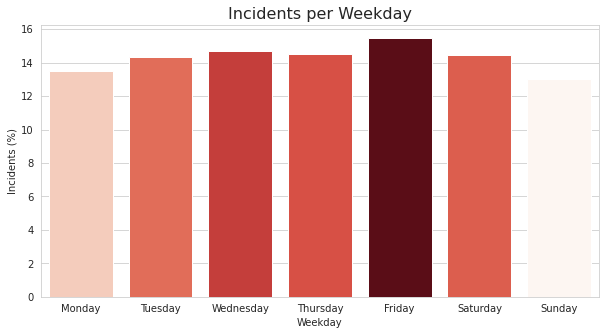

In [7]:
from matplotlib import cm

data = train_df.groupby('CMPLNT_FR_DTDayofweek')['OFNS_DESC'].count()

def replace(list, dictionary):
    return [data_week_dict.get(item, item) for item in list]

data_week_dict = {
    0: "Monday",
    1:"Tuesday",
    2:"Wednesday",
    3:"Thursday",
    4:"Friday",
    5:"Saturday",
    6:"Sunday"
}

plt.figure(figsize=(10, 5))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        replace(data.index,data_week_dict), (data.values / data.values.sum()) * 100,
        orient='v',
        palette=cm.ScalarMappable(cmap='Reds').to_rgba(data.values))

plt.title('Incidents per Weekday', fontdict={'fontsize': 16})
plt.xlabel('Weekday')
plt.ylabel('Incidents (%)')

plt.show()

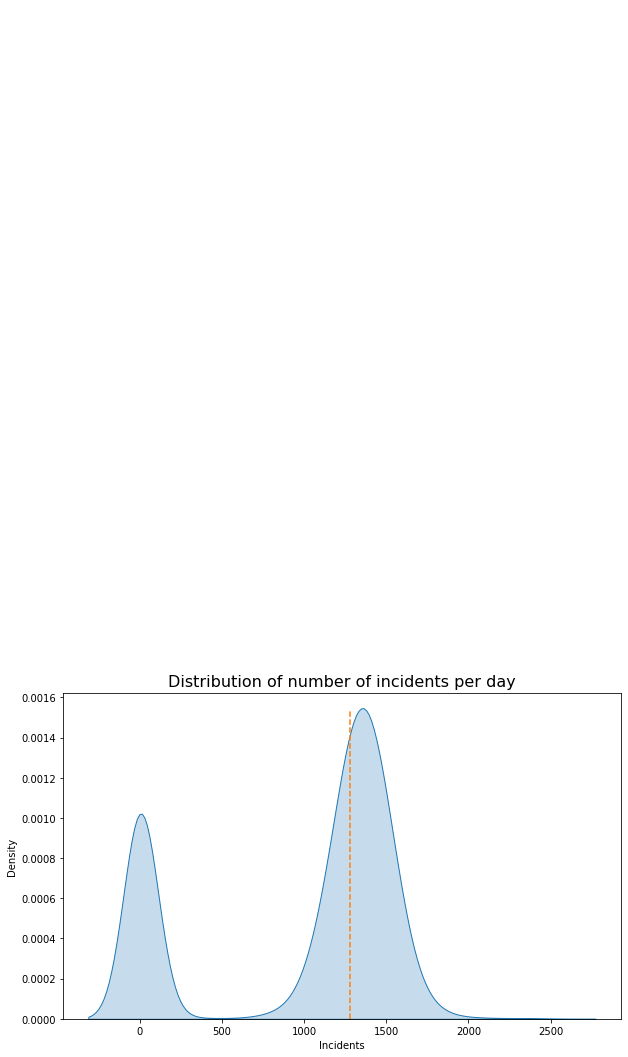

In [12]:
col = sns.color_palette()

# train_df['Date'] = train_df.CMPLNT_FR_DT.dt.date
# train_df['Hour'] = train_df.CMPLNT_FR_DT.dt.hour

plt.figure(figsize=(10, 6))
data = train_df.groupby('Date').count().iloc[:, 0]
sns.kdeplot(data=data, shade=True)
plt.axvline(x=data.median(), ymax=0.95, linestyle='--', color=col[1])
plt.annotate(
    'Median: ' + str(data.median()),
    xy=(data.median(), 0.004),
    xytext=(200, 0.005),
    arrowprops=dict(arrowstyle='->', color=col[1], shrinkB=10))
plt.title(
    'Distribution of number of incidents per day', fontdict={'fontsize': 16})
plt.xlabel('Incidents')
plt.ylabel('Density')
plt.show()

del data

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


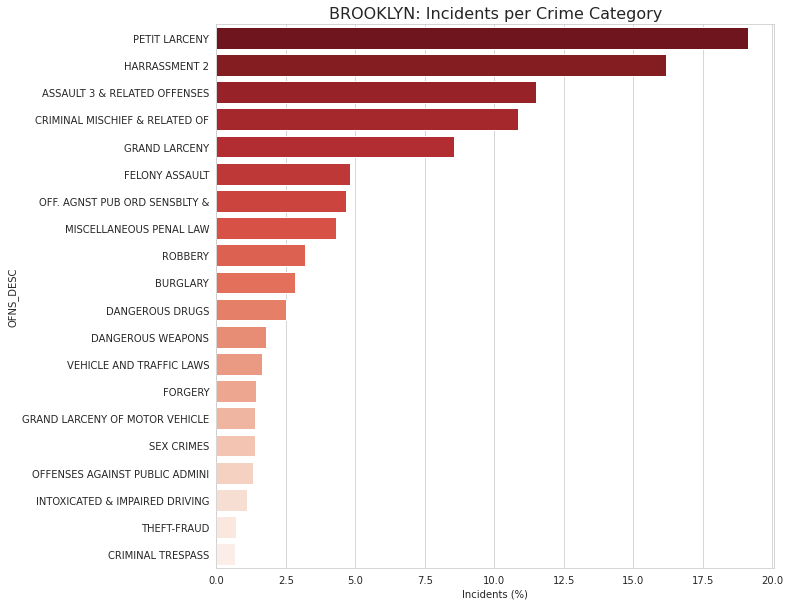

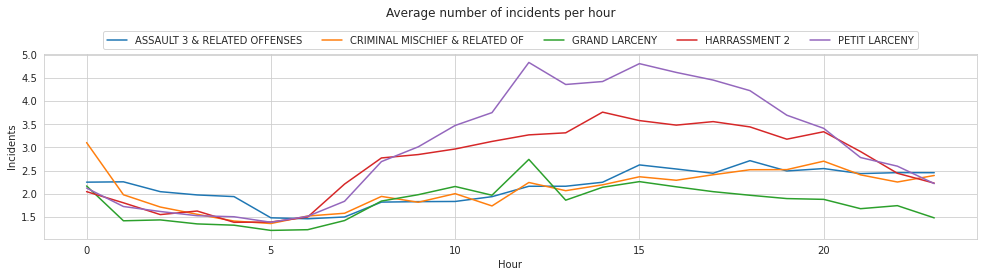

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


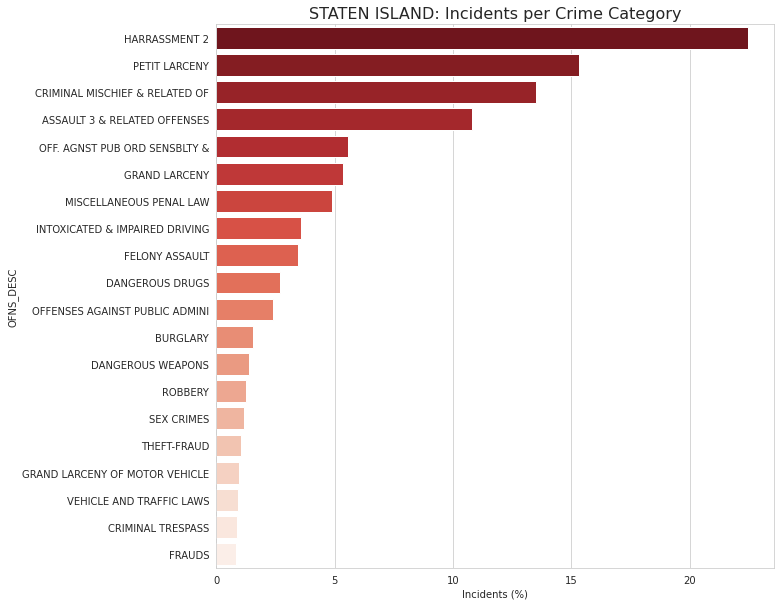

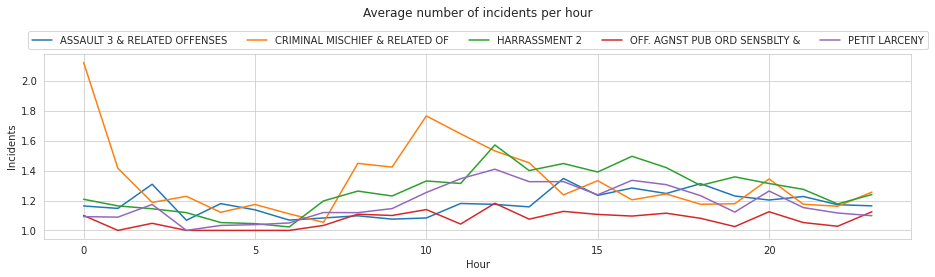

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


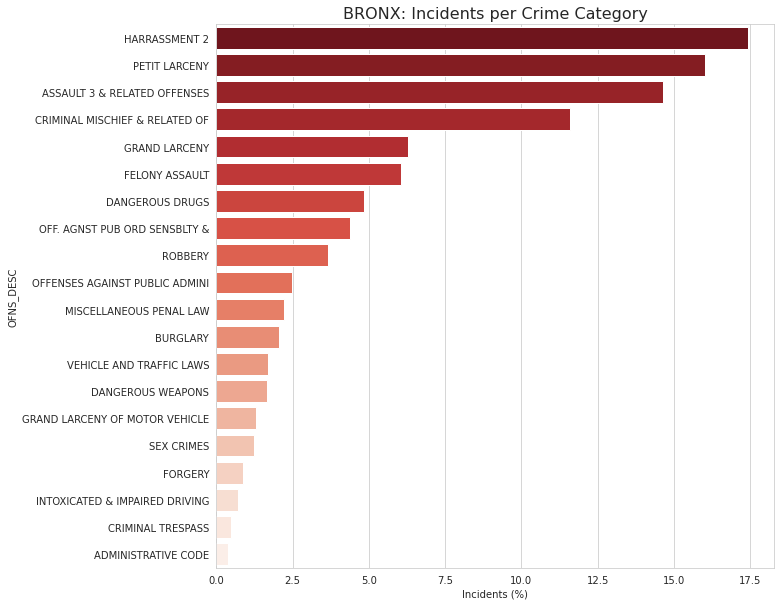

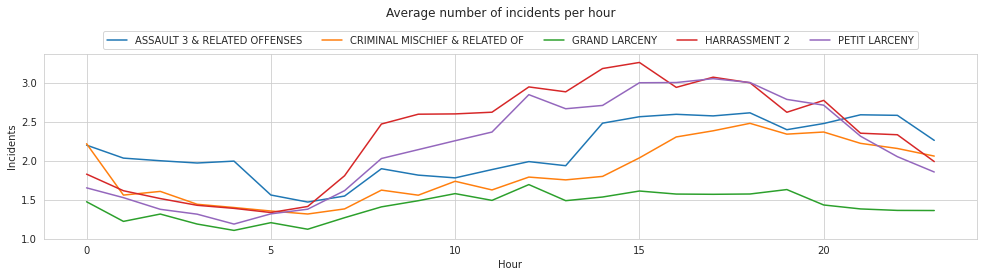

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


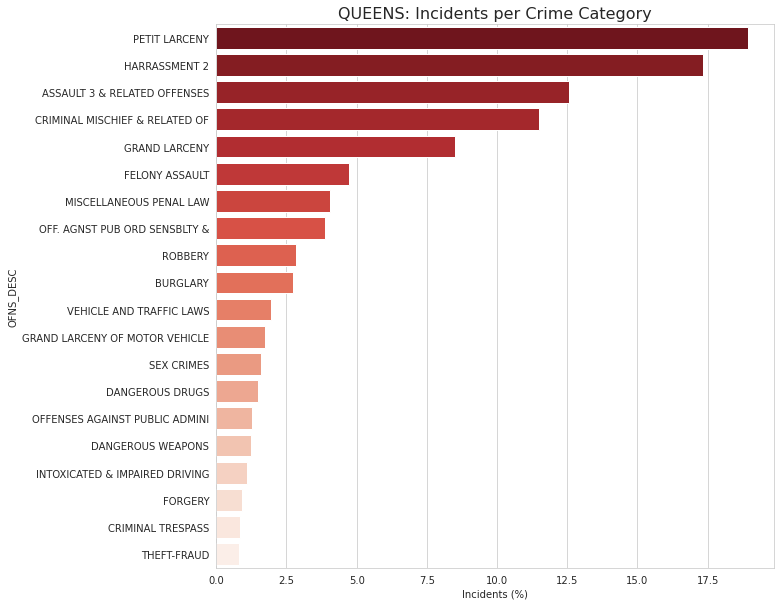

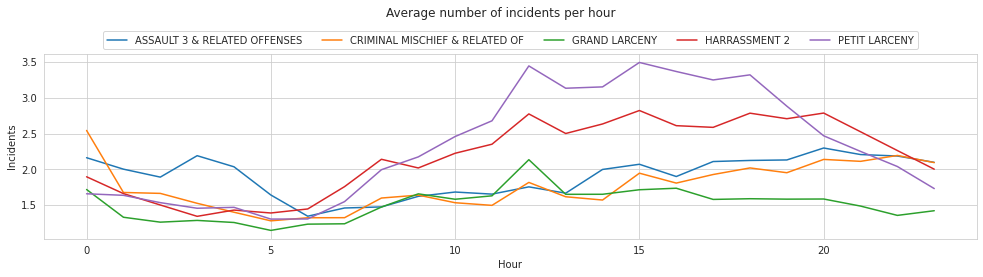

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


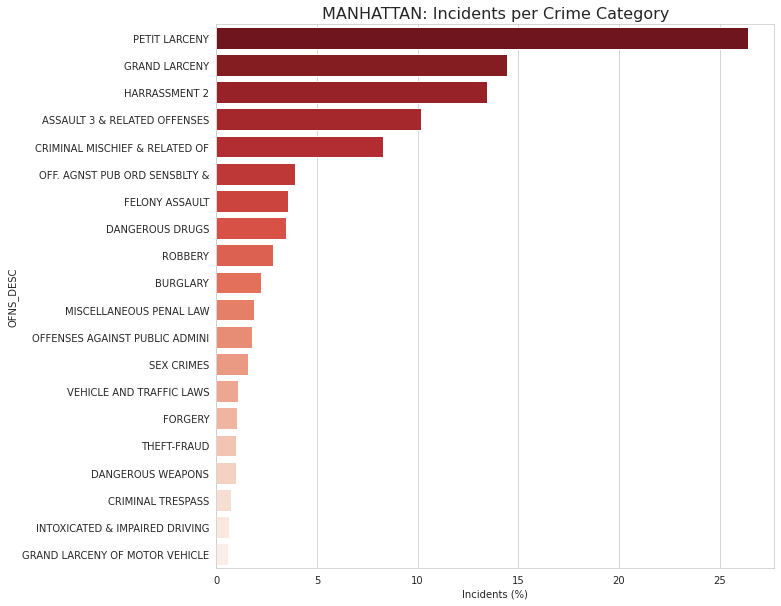

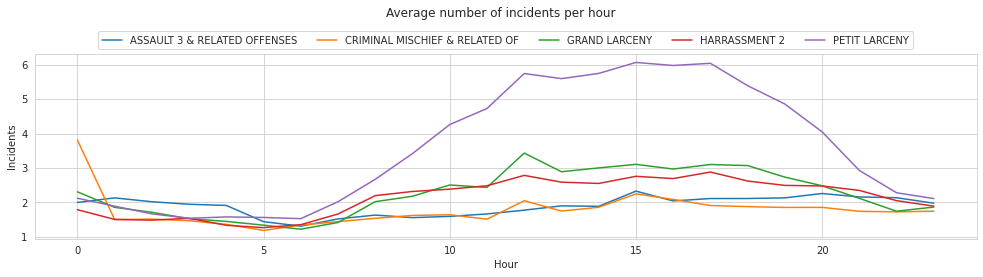

In [13]:
for value in train_df['BORO_NM'].unique():
  # SHOW INCIDENTS PER CRIME CATEGORY PER BORO
  data = train_df.loc[(train_df['BORO_NM']==value)&(train_df['CMPLNT_FR_DTYear']==2019)].groupby('OFNS_DESC').count().iloc[:, 0].sort_values(
      ascending=False)[:20]
  # data = data.reindex(np.append(np.delete(data.index, 1), 'OTHER OFFENSES'))

  plt.figure(figsize=(10, 10))
  with sns.axes_style("whitegrid"):
      ax = sns.barplot(
          (data.values / data.values.sum()) * 100,
          data.index,
          orient='h',
          palette="Reds_r")

  plt.title(f'{value}: Incidents per Crime Category', fontdict={'fontsize': 16})
  plt.xlabel('Incidents (%)')

  plt.show()
  
  # SHOW FREQUENCY OF CRIMES PER TIME OF DAY
  
  top_five_crimes  = data.index.tolist()[:5]
  
  data = train_df.loc[(train_df['CMPLNT_FR_DTYear']==2019)&(train_df['BORO_NM']==value)&(train_df['OFNS_DESC'].isin(top_five_crimes))].groupby(['Hour', 'Date', 'OFNS_DESC'],
                       as_index=False).count().iloc[:, :4]

  data = data.groupby(['Hour', 'OFNS_DESC']).mean()

  data['Hour'] = data.index
  data['OFNS_DESC'] = data.index
  data['Hour'] = data['Hour'].apply(lambda x: x[0])
  data['OFNS_DESC'] = data['OFNS_DESC'].apply(lambda x: x[1])
  data.rename(columns={'CMPLNT_NUM': 'Incidents'}, inplace=True)
  data = data.reset_index(drop=True)

  sns.set_style("whitegrid")
  fig, ax = plt.subplots(figsize=(14, 4))
  ax = sns.lineplot(x='Hour', y='Incidents', data=data, hue='OFNS_DESC')
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6)
  plt.suptitle('Average number of incidents per hour')
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()


  del data

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


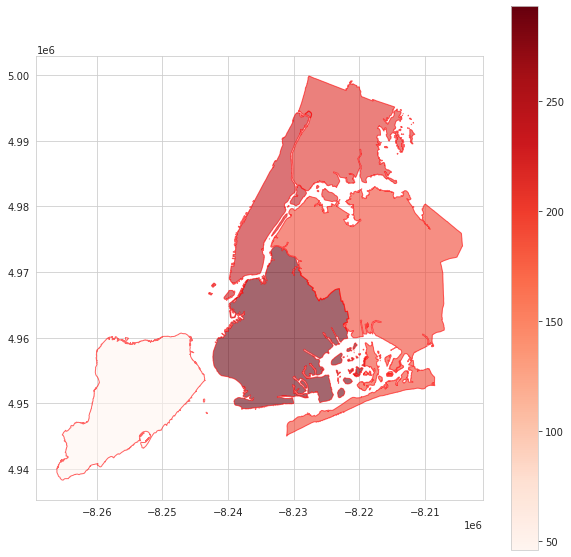

In [14]:
boroughs = gpd.read_file('drive/My Drive/nyc_crime_project/Borough Boundaries/geo_export_d42e15aa-099e-4eda-8b87-8beec1f931a8.shp')
# Defining the coordinate system to longitude/latitude
boroughs.crs={'init': 'epsg:4326'}
boroughs['boro_name'] = boroughs['boro_name'].apply(lambda x: str.lower(x))


train_df = train_df.rename(columns={'BORO_NM':'boro_name'})
train_df['boro_name'] = train_df['boro_name'].apply(lambda x: str.lower(x))

# Merging our train dataset with the geo-dataframe
boroughs = boroughs.merge(
    train_df.groupby('boro_name').count().iloc[:, 1],
    how='inner',
    left_on='boro_name',
    right_index=True)

# Transforming the coordinate system to Spherical Mercator for
# compatibility with the tiling background
boroughs = boroughs.to_crs({'init': 'epsg:3857'})

# Calculating the incidents per day for every district
train_days = train_df.groupby('CMPLNT_FR_DT').count().shape[0]
boroughs['inc_per_day'] = boroughs.CMPLNT_FR_DT/train_days

# Ploting the data
fig, ax = plt.subplots(figsize=(10, 10))
boroughs.plot(
    column='inc_per_day',
    cmap='Reds',
    alpha=0.6,
    edgecolor='r',
    linestyle='-',
    linewidth=1,
    legend=True,
    ax=ax)

In [15]:
!pip install contextily --quiet
import contextily as ctx

     |████████████████████████████████| 18.3MB 357kB/s 


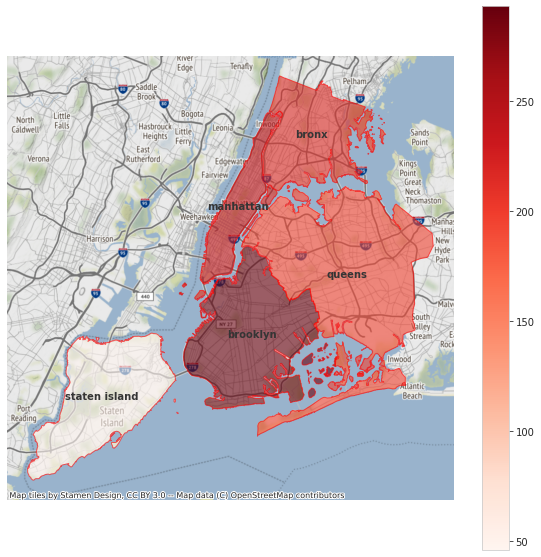

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
# Adding the name of the districts
for index in boroughs.index:
    plt.annotate(
        boroughs.loc[index].boro_name,
        (boroughs.loc[index].geometry.centroid.x,
         boroughs.loc[index].geometry.centroid.y),
        color='#353535',
        # fontsize='large',
        fontweight='heavy',
        horizontalalignment='center'
    )
ax.set_axis_off()
boroughs.plot(
    column='inc_per_day',
    cmap='Reds',
    alpha=0.6,
    edgecolor='r',
    linestyle='-',
    linewidth=1,
    legend=True,
    ax=ax)
ctx.add_basemap(ax)